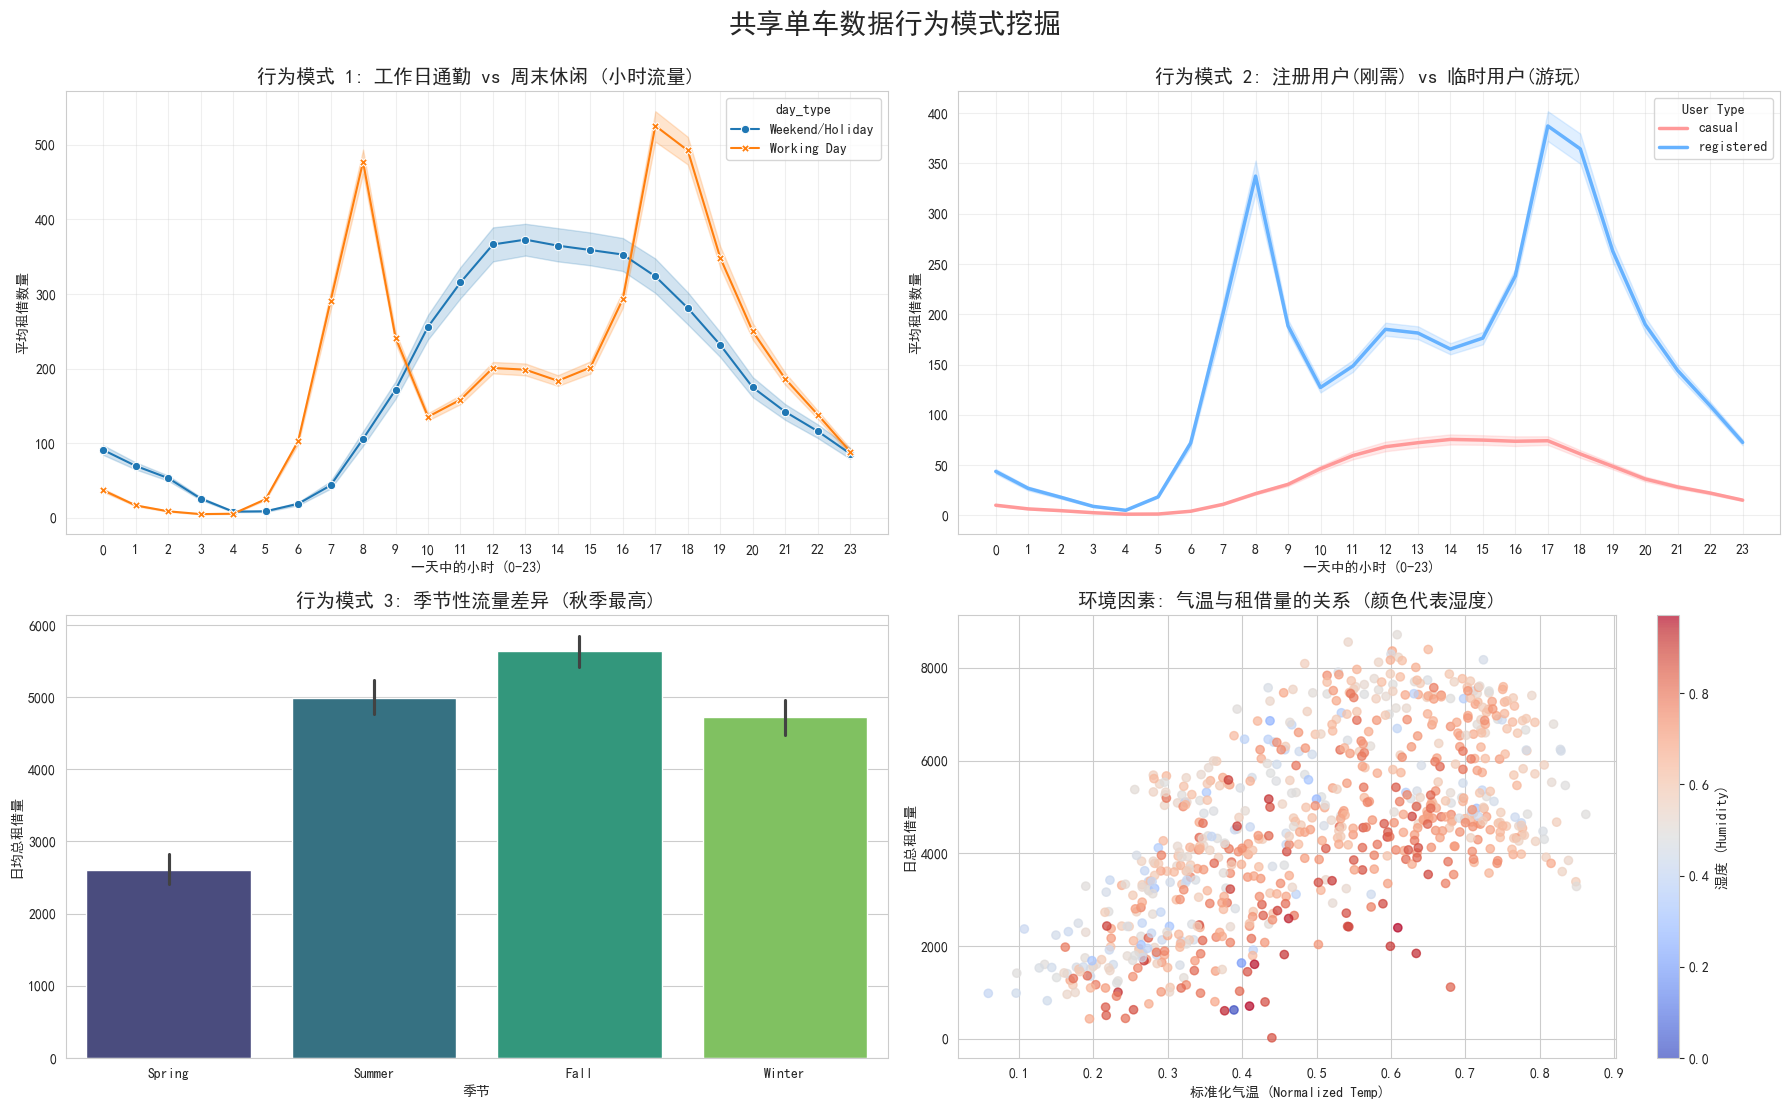

--- 关键统计洞察 ---
1. 注册用户占比: 81.2%
2. 临时用户占比: 18.8%
3. 工作日流量峰值时刻: 17:00
4. 周末流量峰值时刻: 13:00

--- 环境因素相关性 (与总租借量) ---
cnt          1.000000
temp         0.627494
hum         -0.100659
windspeed   -0.234545
Name: cnt, dtype: float64


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置绘图风格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'sans-serif'] # 适配中文显示，如无字体可删去
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据加载与预处理
# ==========================================
def load_and_process_data():
    # 读取数据
    df_day = pd.read_csv('day.csv')
    df_hour = pd.read_csv('hour.csv')
    
    # 映射可读的标签，方便绘图理解
    # 季节映射: 1:Spring, 2:Summer, 3:Fall, 4:Winter
    season_map = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
    
    # 星期映射
    weekday_map = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
    
    # 天气映射
    weather_map = {1: 'Clear/Cloudy', 2: 'Mist/Cloudy', 3: 'Light Snow/Rain', 4: 'Heavy Rain/Ice'}
    
    # 应用映射到 hour 数据集 (分析主要基于 hour 数据集，因为它颗粒度更细)
    df_hour['season_label'] = df_hour['season'].map(season_map)
    df_hour['weekday_label'] = df_hour['weekday'].map(weekday_map)
    df_hour['weather_label'] = df_hour['weathersit'].map(weather_map)
    
    # 创建一个标识工作日/非工作日的文本标签
    df_hour['day_type'] = df_hour['workingday'].apply(lambda x: 'Working Day' if x == 1 else 'Weekend/Holiday')
    
    return df_day, df_hour

df_day, df_hour = load_and_process_data()

# ==========================================
# 2. 可视化分析
# ==========================================

fig = plt.figure(figsize=(18, 12))
plt.suptitle('共享单车数据行为模式挖掘', fontsize=20, y=0.95)

# ------------------------------------------
# 图 1: 一天中的小时趋势 (工作日 vs 周末)
# 目的: 展示“通勤”与“休闲”的截然不同的时间分布
# ------------------------------------------
ax1 = fig.add_subplot(2, 2, 1)
sns.lineplot(data=df_hour, x='hr', y='cnt', hue='day_type', style='day_type', 
             markers=True, dashes=False, ax=ax1, palette='tab10')
ax1.set_title('行为模式 1: 工作日通勤 vs 周末休闲 (小时流量)', fontsize=14)
ax1.set_xlabel('一天中的小时 (0-23)')
ax1.set_ylabel('平均租借数量')
ax1.set_xticks(range(0, 24))
ax1.grid(True, alpha=0.3)

# ------------------------------------------
# 图 2: 用户分层分析 (注册用户 vs 临时用户)
# 目的: 展示不同用户群体的每小时行为差异
# ------------------------------------------
ax2 = fig.add_subplot(2, 2, 2)
# 为了绘图方便，我们将数据融化(Melt)成长格式
hour_melted = df_hour.melt(id_vars=['hr'], value_vars=['casual', 'registered'], 
                           var_name='User Type', value_name='Count')

sns.lineplot(data=hour_melted, x='hr', y='Count', hue='User Type', 
             ax=ax2, palette=['#FF9999', '#66B2FF'], linewidth=2.5)
ax2.set_title('行为模式 2: 注册用户(刚需) vs 临时用户(游玩)', fontsize=14)
ax2.set_xlabel('一天中的小时 (0-23)')
ax2.set_ylabel('平均租借数量')
ax2.set_xticks(range(0, 24))
ax2.grid(True, alpha=0.3)

# ------------------------------------------
# 图 3: 季节与天气的宏观影响
# 目的: 展示季节性趋势
# ------------------------------------------
ax3 = fig.add_subplot(2, 2, 3)
order = ['Spring', 'Summer', 'Fall', 'Winter']
sns.barplot(data=df_day, x='season', y='cnt', ax=ax3, palette='viridis', estimator=np.mean)
ax3.set_xticklabels(order)
ax3.set_title('行为模式 3: 季节性流量差异 (秋季最高)', fontsize=14)
ax3.set_xlabel('季节')
ax3.set_ylabel('日均总租借量')

# ------------------------------------------
# 图 4: 温度与租借量的相关性
# 目的: 验证环境因素
# ------------------------------------------
ax4 = fig.add_subplot(2, 2, 4)
sc = ax4.scatter(df_day['temp'], df_day['cnt'], c=df_day['hum'], cmap='coolwarm', alpha=0.7)
ax4.set_title('环境因素: 气温与租借量的关系 (颜色代表湿度)', fontsize=14)
ax4.set_xlabel('标准化气温 (Normalized Temp)')
ax4.set_ylabel('日总租借量')
plt.colorbar(sc, ax=ax4, label='湿度 (Humidity)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ==========================================
# 3. 简单的统计输出
# ==========================================
print("--- 关键统计洞察 ---")
print(f"1. 注册用户占比: {df_day['registered'].sum() / df_day['cnt'].sum():.1%}")
print(f"2. 临时用户占比: {df_day['casual'].sum() / df_day['cnt'].sum():.1%}")

peak_hour_work = df_hour[df_hour['workingday']==1].groupby('hr')['cnt'].mean().idxmax()
peak_hour_weekend = df_hour[df_hour['workingday']==0].groupby('hr')['cnt'].mean().idxmax()
print(f"3. 工作日流量峰值时刻: {peak_hour_work}:00")
print(f"4. 周末流量峰值时刻: {peak_hour_weekend}:00")

# 计算相关性
corr = df_day[['temp', 'hum', 'windspeed', 'cnt']].corr()['cnt']
print("\n--- 环境因素相关性 (与总租借量) ---")
print(corr.sort_values(ascending=False))